# Extending linear regression to non-linear models

In the previous chapters, we have learned how to model a dataset with a linear model i.e. where the variable to predict is a linear sum $y = w_0 * x_0 + w_1 * x_1 \ldots + b$.  However sometimes the relation between two variables is not linear like in a parabola $y = a * x^2 +b$. We will now see that we can "add" features to our dataset to model exactly such as relationship and use regular linear regression to solve our problem.

## A non-linear relation

We will use here another dataset which is a collection of geometrical properties measured on wheat seeds (dataset from the UCI repository https://archive-beta.ics.uci.edu/ml/datasets/seeds). We have here to set manually the columns names as they are not included:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

seeds = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                    sep='\t', on_bad_lines='skip', names=['area', 'perimeter', 'compactness', 'length', 'width', 'symmetry_coef', 'length_groove', 'seed_type']
)

In [2]:
seeds.head()

,area,perimeter,compactness,length,width,symmetry_coef,length_groove,seed_type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Now we look at the relation between length and width of seeds:

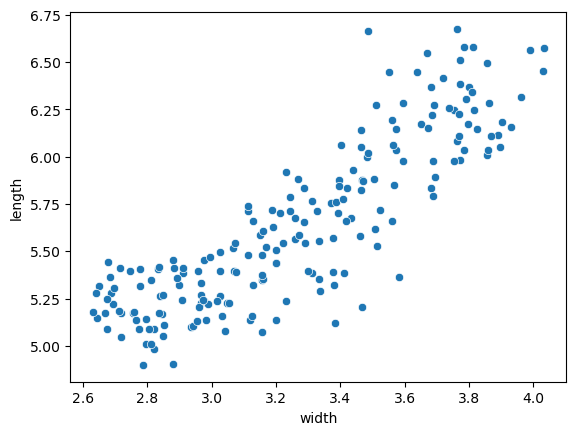

In [3]:
sns.scatterplot(data=seeds, x='width', y='length');

We can try to do a linear regression through these points but we already see that the fit won't be very good. The data are sort of flat on the left and do not fall on a line:

/Users/gw18g940/mambaforge/envs/EHML2023/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


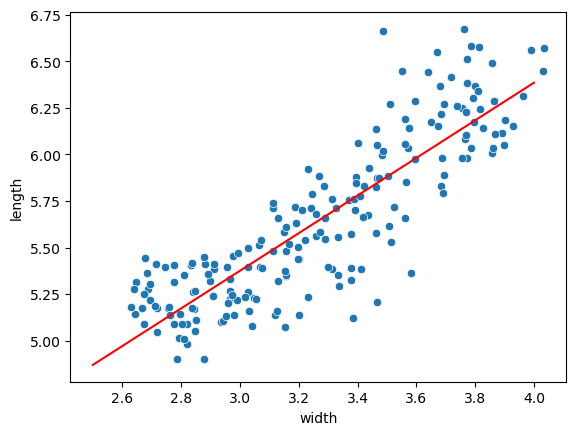

In [4]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X=seeds[['width']], y=seeds['length']);

sns.scatterplot(data=seeds, x='width', y='length')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model.predict(np.arange(2.5, 4.1, 0.1)[:, np.newaxis]), color='r');

It looks like we could use some **non-linear** terms here. For example a parabola $\texttt{length} = w_0 * \texttt{width} + w_0 * \texttt{width}^2 + b$. Let's try to add one manually by guessing parameters:

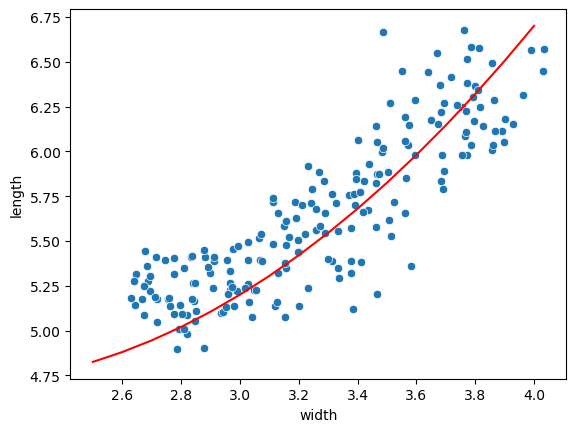

In [5]:
sns.scatterplot(data=seeds, x='width', y='length')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=6.7-2*np.arange(2.5, 4.1, 0.1)+0.5*np.arange(2.5, 4.1, 0.1)**2, color='red');

## Turning linear features into non-linear ones: feature engineering

What did we actually do in our "manual fit" above? We replaced the simple relation $y=w_0*x_0+b$ by $y=w_0*x_0+w_1*x^2+b$. In other terms instead of doing a simple linear regression with just one feature $x_0 = \texttt{width}$, we now do a multiple regression with two features $x_0=\texttt{width}$ and $x_0^2=\texttt{width}^2$. That's the trick: we can just *create* a feature that doesn't actually exist by taking the square (or any other function) of the feature $x_0$ and just treat it like another feature!. We could even combined multiple features to create a new one e.g. $x_1=\frac{length}{perimeter}$ if we think that, from what we know of the data, this could make sense. This manual creation of new variables is called **feature engineering**.

Let's try to do this explicitly. First we add a feature to our dataset, the square of ```width```:

In [6]:
seeds['width2'] = seeds['width']**2

Now we do a multiple regression with a feature table of two variables:

In [7]:
X = seeds[['width', 'width2']]
y = seeds['length']

And we can proceed with the fit:

In [8]:
model_nonlin = linear_model.LinearRegression()
model_nonlin.fit(X=X, y=y);

Now our model takes two features as input, so we can't just call:

In [9]:
model_nonlin.predict(np.arange(2.5, 4.1, 0.1)[:, np.newaxis])

/Users/gw18g940/mambaforge/envs/EHML2023/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but LinearRegression is expecting 2 features as input.

We have to create a table that contains the width values we want to do predictions on **as well as the square of those values**. So we just stack two lists $x$ and $x^2$ together:

In [10]:
X_pred = np.stack([np.arange(2.5, 4.1, 0.1), np.arange(2.5, 4.1, 0.1)**2], axis=1)

We can finally look at our plot:

/Users/gw18g940/mambaforge/envs/EHML2023/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/gw18g940/mambaforge/envs/EHML2023/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


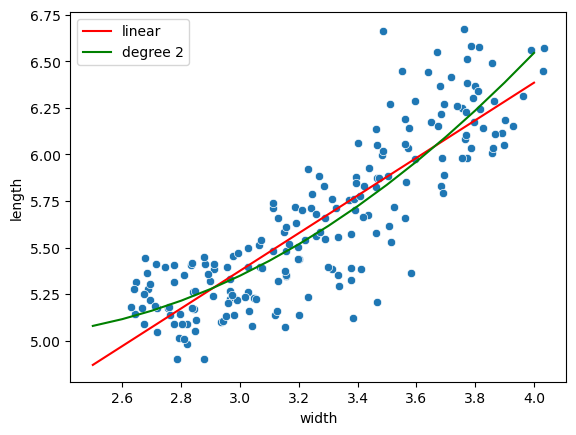

In [11]:
sns.scatterplot(data=seeds, x='width', y='length')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model.predict(np.arange(2.5, 4.1, 0.1)[:, np.newaxis]), color='r', label='linear')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model_nonlin.predict(X_pred), color='g', label='degree 2')
plt.legend();

We see that the fit improved. We can measure the mean square error using the pre-made function from the ```metrics``` module. That function does for us the operation of averaging the squared difference of actual and predicted values $(y_i-y_i^{pred})^2$:

In [12]:
from sklearn import metrics

In [13]:
metrics.mean_squared_error(seeds['length'], model.predict(seeds[['width']]))

0.050078880741250296

In [14]:
metrics.mean_squared_error(seeds['length'], model_nonlin.predict(seeds[['width', 'width2']]))

0.04664755934792926

## Adding features with scikit-learn

Very often one just needs polynomial features, as we have done above by raising a feature to a certain power. scikit-learn allows us to automate this process using the ```PolynomialFeatures``` object:

In [15]:
from sklearn.preprocessing import PolynomialFeatures

It works just like almost every other object in scikit-learn: we initialize it (with some options) and then can pass data through it via a method. Note that here we use ```fit_transform``` as we want to directly transform the data and not just train a model. Let's make an degree 2 fit again:

In [16]:
poly = PolynomialFeatures(degree=2)

In [17]:
X = seeds[['width']]

X_poly = poly.fit_transform(X)

Now we can use it as before:

In [18]:
model_poly = linear_model.LinearRegression()
model_poly.fit(X=X_poly, y=y);

To create x values to be predicted, we can pass it through the same polynomial object:

In [19]:
X_pred = np.arange(2.5, 4.1, 0.1)
X_pred = poly.fit_transform(X_pred[:, np.newaxis])

/Users/gw18g940/mambaforge/envs/EHML2023/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


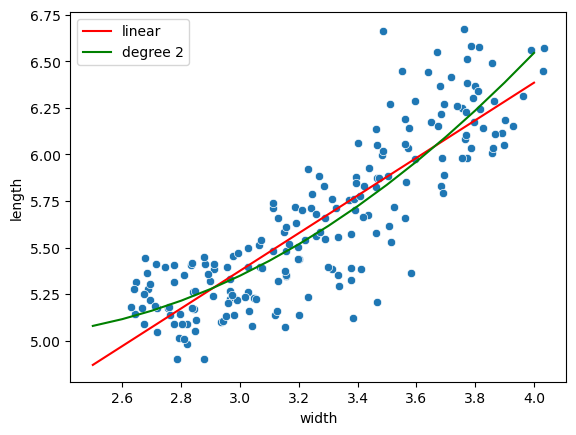

In [20]:
sns.scatterplot(data=seeds, x='width', y='length')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model.predict(np.arange(2.5, 4.1, 0.1)[:, np.newaxis]), color='r', label='linear')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model_poly.predict(X_pred), color='g', label='degree 2')
plt.legend();

We can now even try more complex models of different degrees. For example degree 4:

In [21]:
X = seeds[['width']]
y = seeds['length']

poly4 = PolynomialFeatures(degree=4)
X_poly4 = poly4.fit_transform(X)
model_poly4 = linear_model.LinearRegression()
model_poly4.fit(X=X_poly4, y=y);
X_pred4 = np.arange(2.5, 4.1, 0.1)
X_pred4 = poly4.fit_transform(X_pred4[:, np.newaxis])

/Users/gw18g940/mambaforge/envs/EHML2023/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


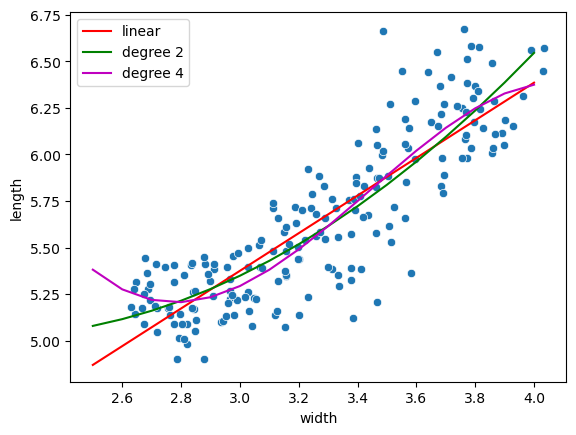

In [22]:
sns.scatterplot(data=seeds, x='width', y='length')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model.predict(np.arange(2.5, 4.1, 0.1)[:, np.newaxis]), color='r', label='linear')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model_poly.predict(X_pred), color='g', label='degree 2')
sns.lineplot(x=np.arange(2.5, 4.1, 0.1), y=model_poly4.predict(X_pred4), color='m', label='degree 4')
plt.legend();

## Over- and under-fitting

How do we decide now if our model is good or if needs to be more or less complex, i.e. of a higher or lower degree? Let's make an example by taking just a sub-sample of the data used above. We can do that with the ```sample``` method of the ```seeds``` DataFrame. We here fix the ```random_state``` so that we can repeatedly get the same random sample:

In [23]:
seeds_sample = seeds.sample(20, random_state=42)
X = seeds_sample[['width']]
y = seeds_sample['length']

Now we do three regressions with degrees 1, 2 and 8, compute their mean square error and plot the results:

mse poly 1: 0.08671288849377715
mse poly 2: 0.08408069132799303
mse poly 8: 0.05953982699260687


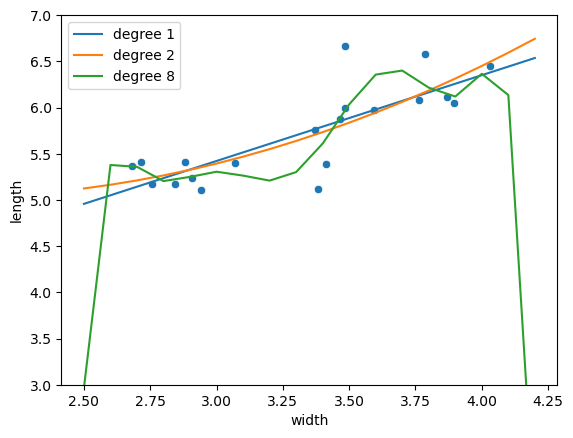

In [24]:
ax = sns.scatterplot(data=seeds_sample, x='width', y='length')
models = {}
for p in [1, 2, 8]:
    poly = PolynomialFeatures(degree=p)
    X_poly = poly.fit_transform(X)
    model_poly = linear_model.LinearRegression()
    model_poly.fit(X=X_poly, y=y);
    models[p] = model_poly
    X_pred = np.arange(2.5, 4.3, 0.1)
    X_pred = poly.fit_transform(X_pred[:, np.newaxis])
    y_pred = model_poly.predict(X_pred)
    
    print(f'mse poly {p}: {metrics.mean_squared_error(y, model_poly.predict(X_poly))}')
    
    sns.lineplot(x=np.arange(2.5, 4.3, 0.1), y=y_pred, label=f'degree {p}')
ax.set_ylim((3,7));

We see that the error is lowest in the degree 8 case, so that model is supposed to be the best. We however see that it looks much less regular than the polynomial of degree 2: it tries to "catch" each point. Conversely the model of degree 1 is too simple and doesn't catch the slight curvature.

As we only took a sub-sample of our data for modeling, we can now use some other sub-sample to check how well the model predicts those data! To take a new sample, we change the ```random_state```:

In [25]:
seeds_sample2 = seeds.sample(20, random_state=22)
X = seeds_sample2[['width']]
y = seeds_sample2['length']

Now we do the prediction for each model:

In [26]:
y_pred_1 = models[1].predict(PolynomialFeatures(degree=1).fit_transform(X))
y_pred_2 = models[2].predict(PolynomialFeatures(degree=2).fit_transform(X))
y_pred_8 = models[8].predict(PolynomialFeatures(degree=8).fit_transform(X))

And we measure the error (distance between data and model):

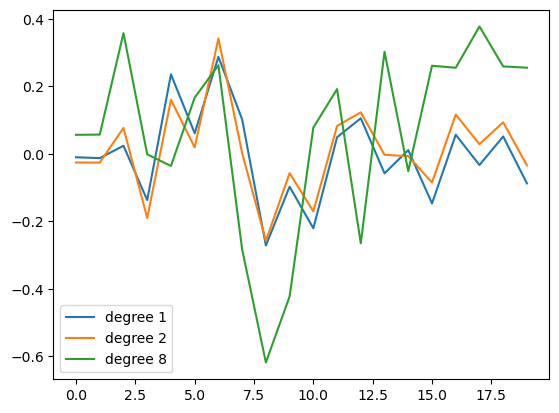

In [27]:
fig, ax = plt.subplots()
plt.plot(y.values-y_pred_1, label=f'degree 1')
plt.plot(y.values-y_pred_2, label=f'degree 2')
plt.plot(y.values-y_pred_8, label=f'degree 8')
ax.legend();

In [28]:
print(f'mse poly 1: {metrics.mean_squared_error(y, y_pred_1)}')
print(f'mse poly 2: {metrics.mean_squared_error(y, y_pred_2)}')
print(f'mse poly 8: {metrics.mean_squared_error(y, y_pred_8)}')

mse poly 1: 0.017839008598722735
mse poly 2: 0.016927014104458408
mse poly 8: 0.07441334715996992


Now we see that the model of degree 8 is much worse than the one of degree 2! What happened is that trying to catch each data point in the first sub-sample of data, the model became too specific to that sub-sample. It is not general enough anymore. The model of degree 1 is still too simple and slightly underperforms the one of degree 2. The degree 2 model cannot catch all data points and is forced to find a mid-way, but it is complex enough to catch the general shape unlike the degree 1 model.

In ML language we can say that the model of degree 1 under-fits the data while the model of degree 2 over-fits them. This is a very common problem in all ML methods, in particular the most complex ones like DL which are prone to over-fitting. One standard way of monitoring this is to do the exact thing we did above: fit or regress on a sub-sample of the data, the **training data** and check the quality of the model on another sub-sample, the **validation data**.

We can actually measure the error for various models and estimate the error on the validation dataset:

In [29]:
seeds_sample = seeds.sample(20, random_state=42)
X = seeds_sample[['width']]
y = seeds_sample['length']

seeds_sample2 = seeds.sample(20, random_state=22)
X2 = seeds_sample2[['width']]
y2 = seeds_sample2['length']

errors = []
for p in range(10):
    poly = PolynomialFeatures(degree=p)
    X_poly = poly.fit_transform(X)
    X_poly2 = poly.fit_transform(X2)
    model_poly = linear_model.LinearRegression()
    model_poly.fit(X=X_poly, y=y);
    
    errors.append(metrics.mean_squared_error(y2, model_poly.predict(X_poly2)))

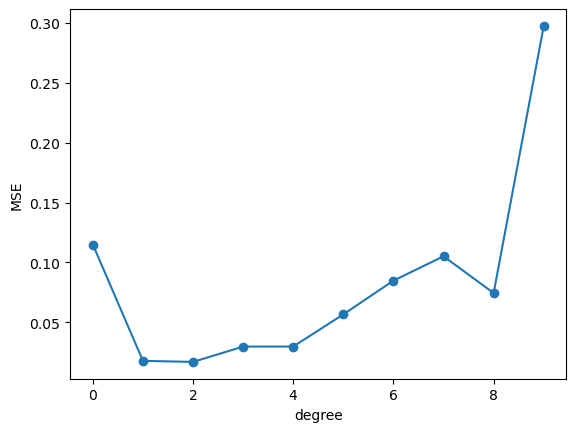

In [30]:
fig, ax = plt.subplots()
ax.plot(errors, '-o')
ax.set_xlabel('degree')
ax.set_ylabel('MSE');


We see clearly in the graph above, that there is an optimum around degree 2, and that simpler or more complex models under- or over-fit the data.

As it is a very common approach to split a dataset into training and validation sets, many ML packages include functions to do the split automatically. For example scikit-learn has a a function called ```train_test_split```:

In [31]:
from sklearn.model_selection import train_test_split

That function takes simply as an input an array or a DataFrame and generates two non-overlapping sub-sets of sizes we can choose. For example:

In [32]:
seeds_train, seeds_test = train_test_split(seeds, test_size=0.3)

In [33]:
print(len(seeds_test))
print(len(seeds_train))

60
139


Here we took a third of the data for test purposes and the rest for training. The fraction used for testing depends on the amount of data that you have. It should in any case contain enough samples to be representative of the complete dataset.

## Exercises

1. Import the King County housing dataset at https://raw.githubusercontent.com/guiwitz/EHML/main/datasets/kc_house_data.csv

2. Look at the relation between price and grade. Try to use polynomial features to find a better model. First try degree 2 then 20.

3. Which one has a better MSE?

4. Use the ```train_test_split``` function to split your data into 20% test and 80% train sets. Create a loop to fit a model of increasing degree and record the MSE error **on the test set** for each. Plot the error. What do you observe? Run again the code to get a different split. Does the plot change?